This notebook evaluates uncertainty estimates and supporting predictions described in "Towards a Trustworthy and Reliable Prithvi Foundation Model"

In [95]:
import numpy as np
import collections
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,  brier_score_loss, precision_score, recall_score
from sklearn.metrics import jaccard_score
from sklearn.calibration import IsotonicRegression
from scipy.stats import pearsonr, spearmanr

Compute calibration, ECE, and Brier score given a directory of predictions

In [96]:
def compute_ece(prob_trues, prob_preds, n_bins):
    """ function to compute expected calibration error (ECE)"""
    
    ece = 0.0
    total_samples = sum(len(prob_true) for prob_true in prob_trues)
    
    for i in range(len(prob_trues)):
        bin_size = len(prob_trues[i])
        bin_weight = bin_size / total_samples
        abs_diff = np.abs(prob_trues[i] - prob_preds[i])
        ece += bin_weight * np.sum(abs_diff) / n_bins
    return ece


def test_calibration(n_montecarlo, n_bins, directory, isotonic):
    """ function to test model calibration with and without isotonic regression """
    
    # isotonic arrays are used to train an isotonic regression for model calibration.
    img_count = 0
    isotonic_X = [] 
    isotonic_y = []
    prob_trues = []
    prob_preds = []
        
    for filename in os.listdir(directory):
        if filename == ".ipynb_checkpoints":
            continue
        
        imgname = filename.split("_")
        filepath = os.path.join(directory, filename)
        if not os.path.exists(f"{filepath}/groundtruth_arr.npy"):
            continue
        gt_arr = np.load(f"{filepath}/groundtruth_arr.npy")
        certainty_pred = np.load(f"{filepath}/certainty_arr{n_montecarlo}.npy")
    
        # replace nan values with 0
        gt_arr = np.nan_to_num(gt_arr, nan=0)
        certainty_pred = np.nan_to_num(certainty_pred, nan=0)
        gt_arr = np.where(gt_arr == -1, 0, gt_arr)
    
        
        gt_arr = gt_arr.flatten()
        certainty_pred = certainty_pred.flatten()

        # if an isotonic regression is given, apply it

        if isotonic:
            certainty_pred = isotonic.predict(certainty_pred)
            
        # compute calibration curve for the current image
        prob_true, prob_pred = calibration_curve(gt_arr, certainty_pred, n_bins=n_bins)
    
        # error checking shapes from bin distribution
        if len(prob_true) != len(prob_pred):
            print(f"Warning: Different lengths of prob_true ({len(prob_true)}) and prob_pred ({len(prob_pred)}) for file {filename}")
        if prob_true.shape[0] < n_bins:
            continue
            
        # Append to lists
        isotonic_X.append(certainty_pred)
        isotonic_y.append(gt_arr)
        
        prob_trues.append(prob_true)
        prob_preds.append(prob_pred)
        img_count+=1
    
    # compute the mean calibration curve 
    mean_prob_true = np.mean(prob_trues, axis=0)
    mean_prob_pred = np.mean(prob_preds, axis=0)
    
    # plot the mean calibration curve
    plt.figure(figsize=(10, 7))
    plt.plot(mean_prob_pred, mean_prob_true, marker='o', label='Mean Calibration curve')
    
    # plot the perfect calibration line
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
    
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.title(f'Mean Calibration Curve ({img_count})')
    plt.legend()
    plt.show()
    
    # calculate ECE
    ece = compute_ece(prob_trues, prob_preds, n_bins=n_bins)
    print(f'Expected Calibration Error (ECE): {ece:.4f}')
    prob_preds = np.concatenate([isotonic_X[i] for i in range(0, len(isotonic_X))])
    true_preds = np.concatenate([isotonic_y[i] for i in range(0, len(isotonic_y))])
    print(f"Brier Score : {brier_score_loss(true_preds, prob_preds)}")
    
    isotonic_X = isotonic_X[:5]
    isotonic_y = isotonic_y[:5]

    return isotonic_X, isotonic_y



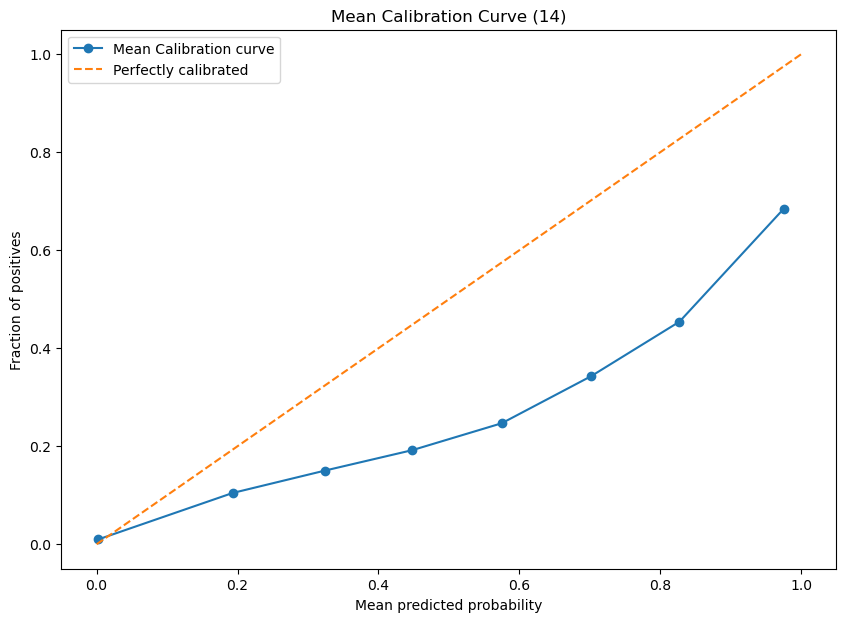

Expected Calibration Error (ECE): 0.2358
Brier Score : 0.035545155661446684


In [97]:
isotonic_X, isotonic_y = test_calibration(n_montecarlo=20, n_bins = 8, directory="inference_results", isotonic = None)

Improve calibration with isotonic regression --> then, test calibration again

Distribution of isotonic regression: 
[0.00498675 0.05677988 0.07083522 0.09069816 0.12396914 0.1350618
 0.16408567 0.18188406 0.21330798 0.22758101 0.26981418 0.29085673
 0.34298365 0.3821287  0.42214912 0.50460364 0.59957489 0.67449284
 0.79907961 0.92787863]



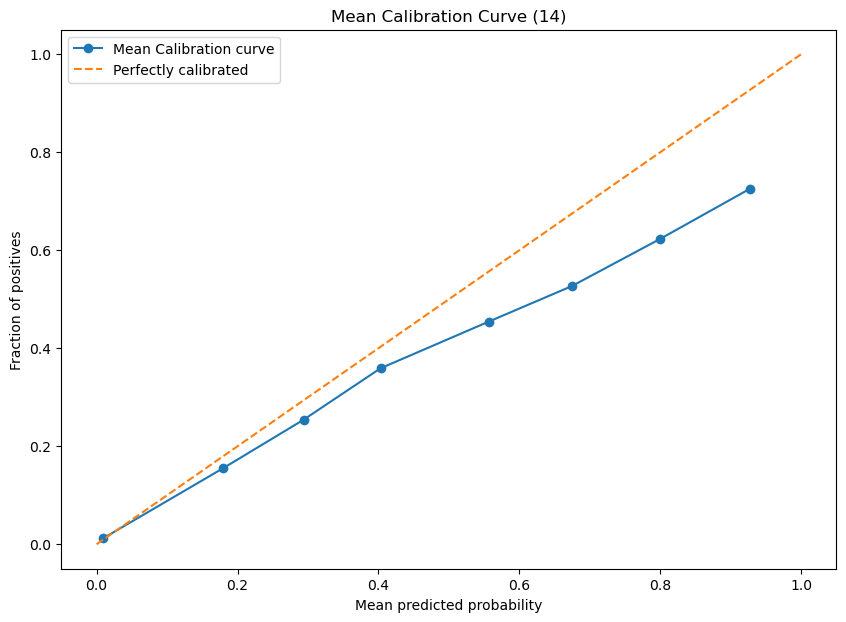

Expected Calibration Error (ECE): 0.1655
Brier Score : 0.031020940022227102


In [98]:
X = np.concatenate([np.array(x) for x in isotonic_X])
y = np.concatenate([np.array(y) for y in isotonic_y])

isotonic = IsotonicRegression(out_of_bounds='clip',
                              y_min=0,
                              y_max=1)
isotonic.fit(X, y)
isotonic_probs = isotonic.predict(isotonic_X[1])
print(f"Distribution of isotonic regression: \n{np.unique(isotonic_probs)}\n")
# rerun the calibration evaluation, passing into our newly trained isotonic regression as a parameter
_, _ = test_calibration(n_montecarlo=20, n_bins = 8, directory="inference_results", isotonic=isotonic)

Create supporting predictions from uncertainty estimates, evaluate them

In [107]:
def remove_random_ones(arr, X):
    one_indices = np.where(arr == 1)[0]
    if len(one_indices) < X:
        raise ValueError("There are not enough 1s in the array to remove.")

    random_indices = np.random.choice(one_indices, size=X, replace=False)
    arr[random_indices] = 0
    return arr

def add_random_ones(arr, X):
    zero_indices = np.where(arr == 0)[0]
    if len(zero_indices) < X:
        raise ValueError("There are not enough 0s in the array to add 1s.")
    
    random_indices = np.random.choice(zero_indices, size=X, replace=False)
    arr[random_indices] = 1
    return arr


def supporting_preds(n_montecarlo, directory, early_stop, control, show_img, free_gain, strict_loss):    
    """ function to create supporting preds, then evaluate them"""
    # keep track of pixel gain/loss for control predictions
    free_pred_pixel_gain = free_gain
    strict_pred_pixel_loss = strict_loss
    count = 0
    test_res = {}
    
    for filename in os.listdir(directory):
        if filename == ".ipynb_checkpoints":
            continue
            
        if count >= early_stop:
            break
            
        imgname = filename.split("_")
        
        filepath = os.path.join(directory, filename)
        
        if not os.path.exists(f"{filepath}/certainty_arr{n_montecarlo}.npy") and not os.path.exists(f"{filepath}/variance_arr{n_montecarlo}.npy"):
            continue
        
        cert_arr = np.load(f"{filepath}/certainty_arr{n_montecarlo}.npy")
        cert_arr = cert_arr.flatten()
        cert_arr = isotonic.predict(cert_arr)
        gt_arr = np.load(f"{filepath}/groundtruth_arr.npy")
        orig_pred = np.load(f"{filepath}/original_pred.npy")
        var_pred = np.load(f"{filepath}/variance_arr{n_montecarlo}.npy")
        image_confidence = np.sum(var_pred <0.1)
        var_pred = cert_arr * (1 - cert_arr)
        var_pred = var_pred.reshape(512,512)
        gt_arr = gt_arr.astype(int)
    
        # thresholding described in the paper
        cert_arr = np.where(cert_arr > 0.7, 1, 0)
        var_pred2 = np.where(var_pred > 0.01, 1, 0)
        var_pred = np.where(var_pred > 0.15, 0, 1)
        gt_arr = np.where(gt_arr == -1, 0, gt_arr)
    
    
        composite_pred = orig_pred * var_pred
        free_pred = orig_pred + var_pred2
        free_pred[free_pred > 1] = 1

        if control:
            composite_pred = remove_random_ones(orig_pred.flatten(), strict_pred_pixel_loss[count])
            free_pred = add_random_ones(orig_pred.flatten(), free_pred_pixel_gain[count])
        else:
            free_pred_pixel_gain.append(np.sum(free_pred == 1) - np.sum(orig_pred==1))
            strict_pred_pixel_loss.append(np.sum(orig_pred == 1) - np.sum(composite_pred==1))        

        
        if show_img:
            fig, axs = plt.subplots(1, 4, figsize=(20, 8))
        
            axs[0].imshow(free_pred.reshape(512,512), cmap='viridis')
            axs[0].set_title('free prediction', fontsize=20)
            axs[0].axis('off')
            
            axs[1].imshow(orig_pred, cmap='viridis')
            axs[1].set_title('original prediction', fontsize=20)
            axs[1].axis('off')
            
            axs[2].imshow(composite_pred.reshape(512,512), cmap='viridis')
            axs[2].set_title('strict prediction', fontsize=20)
            axs[2].axis('off')
            
            axs[3].imshow(gt_arr.reshape(512, 512), cmap='viridis')
            axs[3].set_title('Ground Truth', fontsize=20)
            axs[3].axis('off')
        
            # Adjust spacing and display
            plt.tight_layout()
            plt.show()
            

        if np.sum(gt_arr == 1) == 0:
            continue
            
        gt_arr_flat = gt_arr.flatten()
        orig_pred_flat = orig_pred.flatten()
        composite_pred_flat = composite_pred.flatten()
        composite_pred2_flat = free_pred.flatten()
    
        # calculate metrics
        iou_orig = jaccard_score(gt_arr_flat, orig_pred_flat)
        iou_composite = jaccard_score(gt_arr_flat, composite_pred_flat)
        iou_composite2 = jaccard_score(gt_arr_flat, composite_pred2_flat)
        iou_diff = iou_composite - iou_orig
        iou_diff2 = iou_composite2 - iou_orig
    
        # original prediction and strict prediction differences
        ans_list = [iou_orig, iou_composite, iou_composite2, iou_diff, iou_diff2, image_confidence]
    
        precision_orig = precision_score(orig_pred_flat, gt_arr_flat)
        recall_orig = recall_score(orig_pred_flat, gt_arr_flat)
        precision_composite = precision_score(gt_arr_flat, composite_pred_flat)
        recall_composite = recall_score(gt_arr_flat, composite_pred_flat)
    
        # original prediction and strict prediction precision/recall
        ans_list2 = [
            precision_orig, recall_orig, precision_composite, recall_composite, precision_composite - precision_orig, recall_composite - recall_orig, image_confidence
        ]
        
    
        precision_orig = precision_score(gt_arr_flat, orig_pred_flat)
        recall_orig = recall_score(gt_arr_flat, orig_pred_flat)
        precision_composite = precision_score(gt_arr_flat, composite_pred2_flat)
        recall_composite = recall_score(gt_arr_flat, composite_pred2_flat)
    
        
        # original prediction and free prediction precision/recall
        ans_list3 = [
            precision_orig, recall_orig, precision_composite, recall_composite, precision_composite - precision_orig, recall_composite - recall_orig, image_confidence
        ]

        
        count+=1
    
        
        # save results into a test dictionary (key = image name, value = supporting prediction results
        test_res[filename] = [ans_list, ans_list2, ans_list3]

    return test_res, free_pred_pixel_gain, strict_pred_pixel_loss


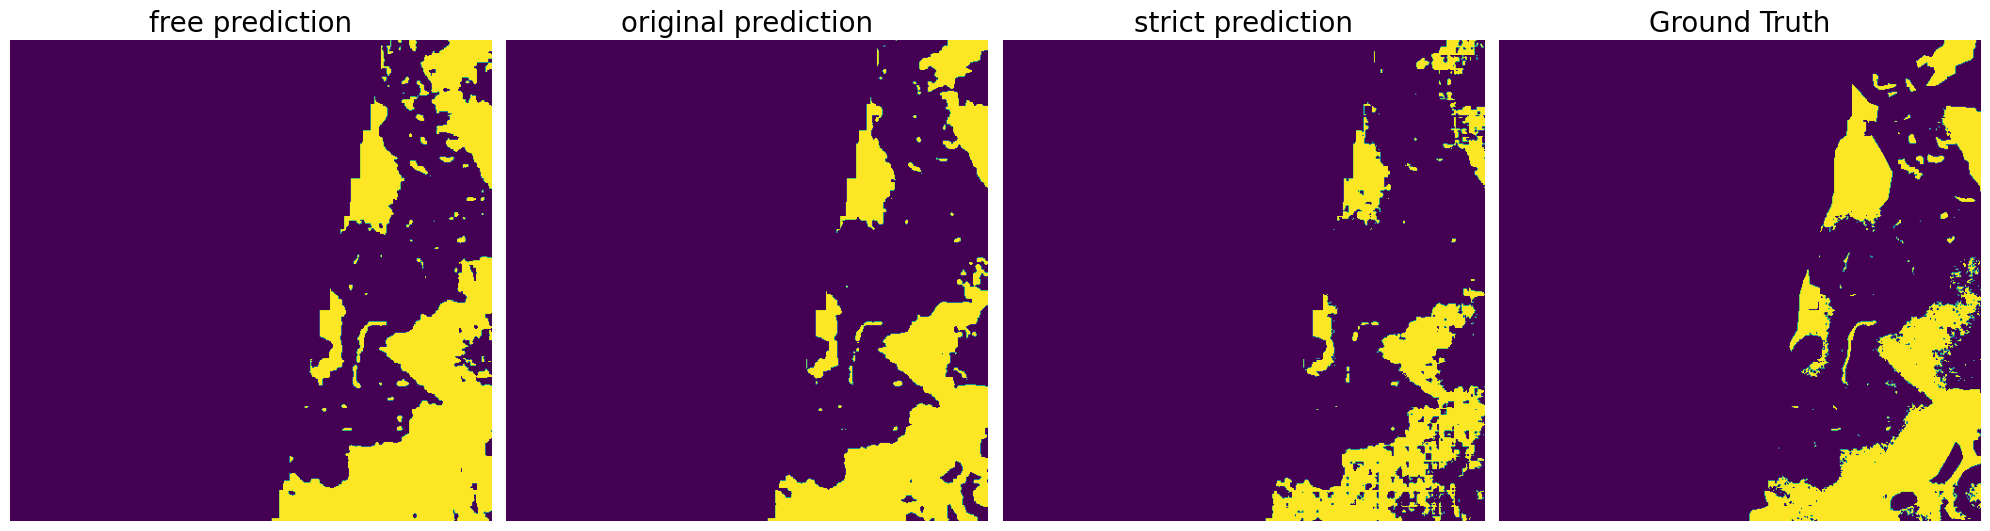

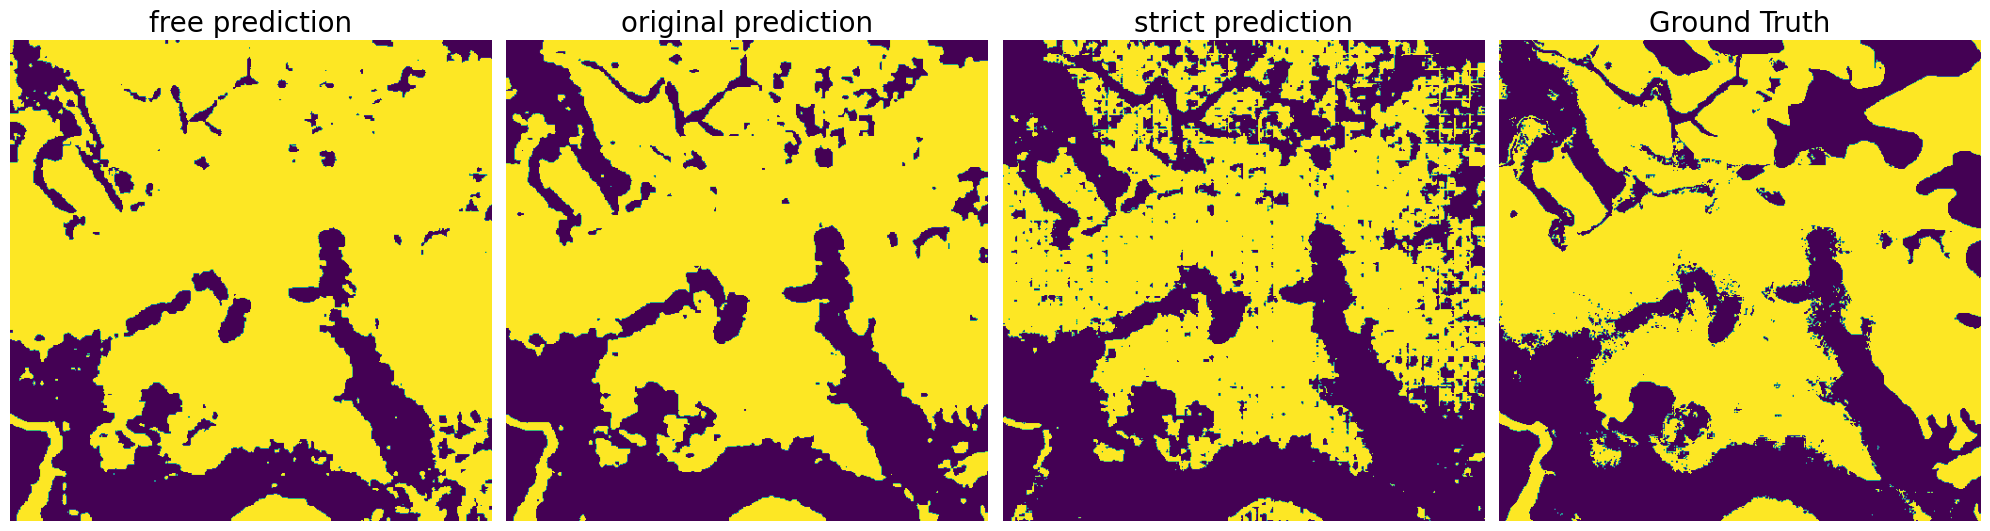

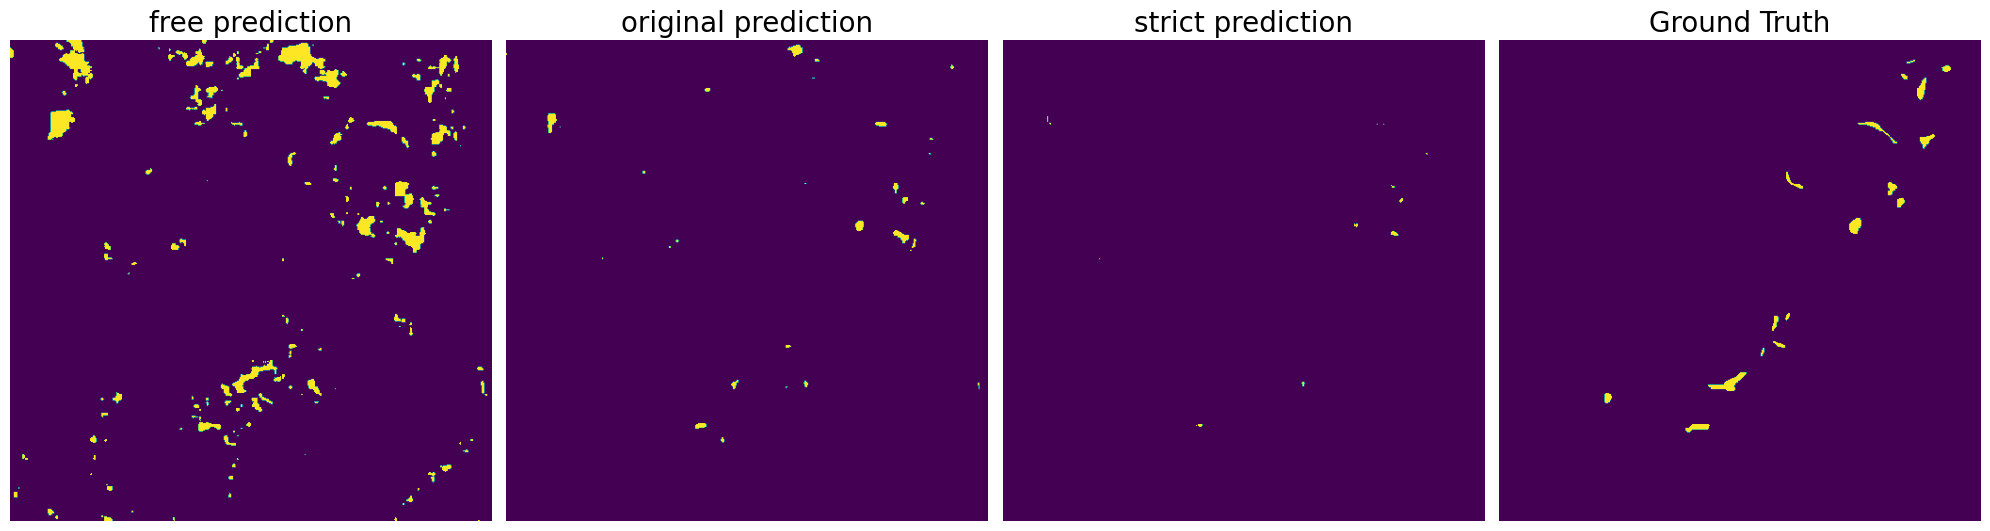

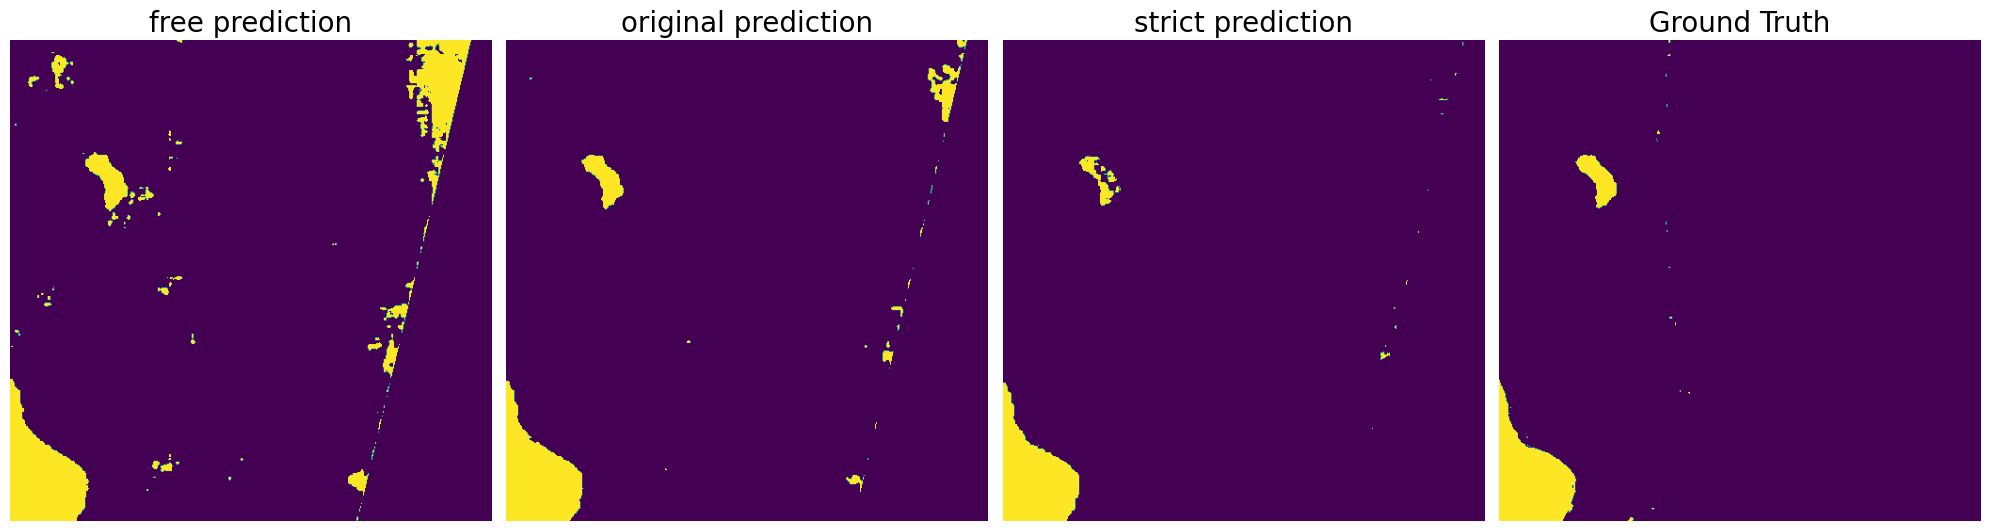

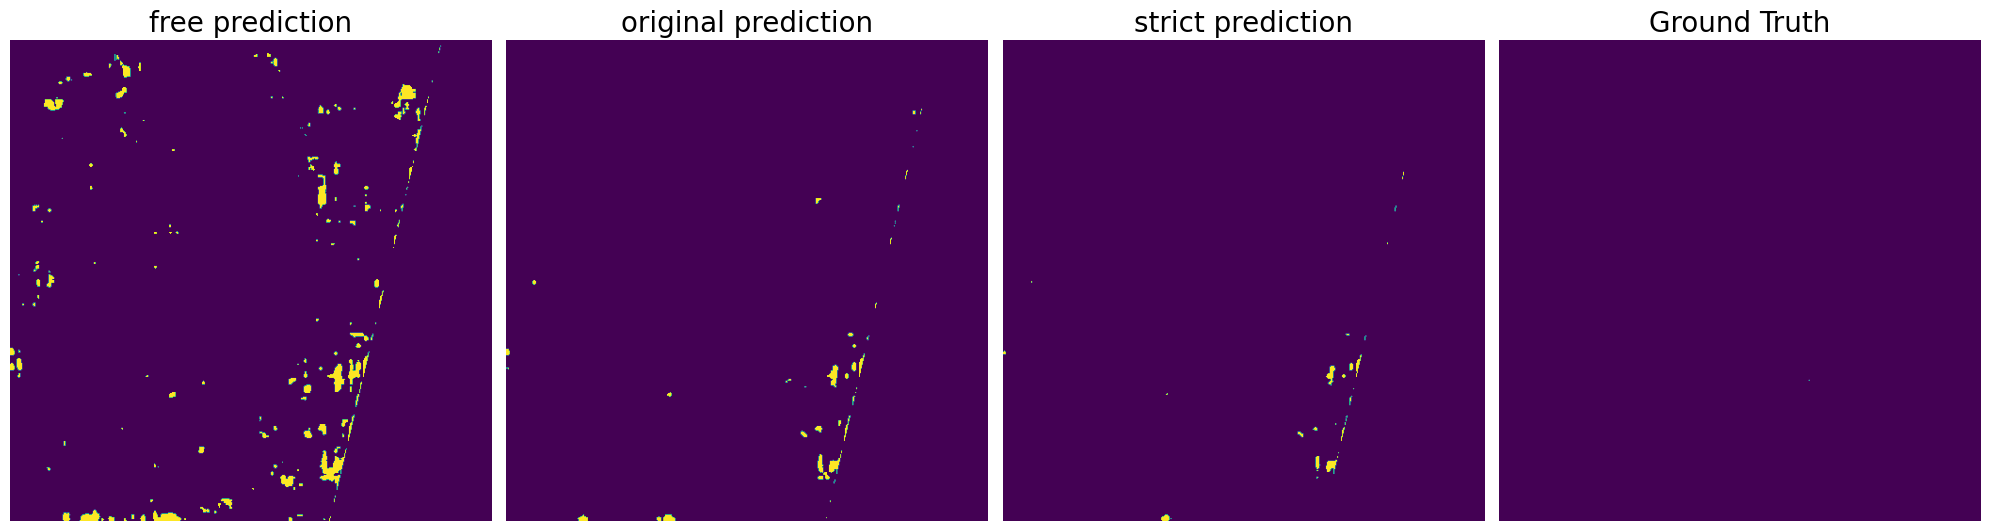

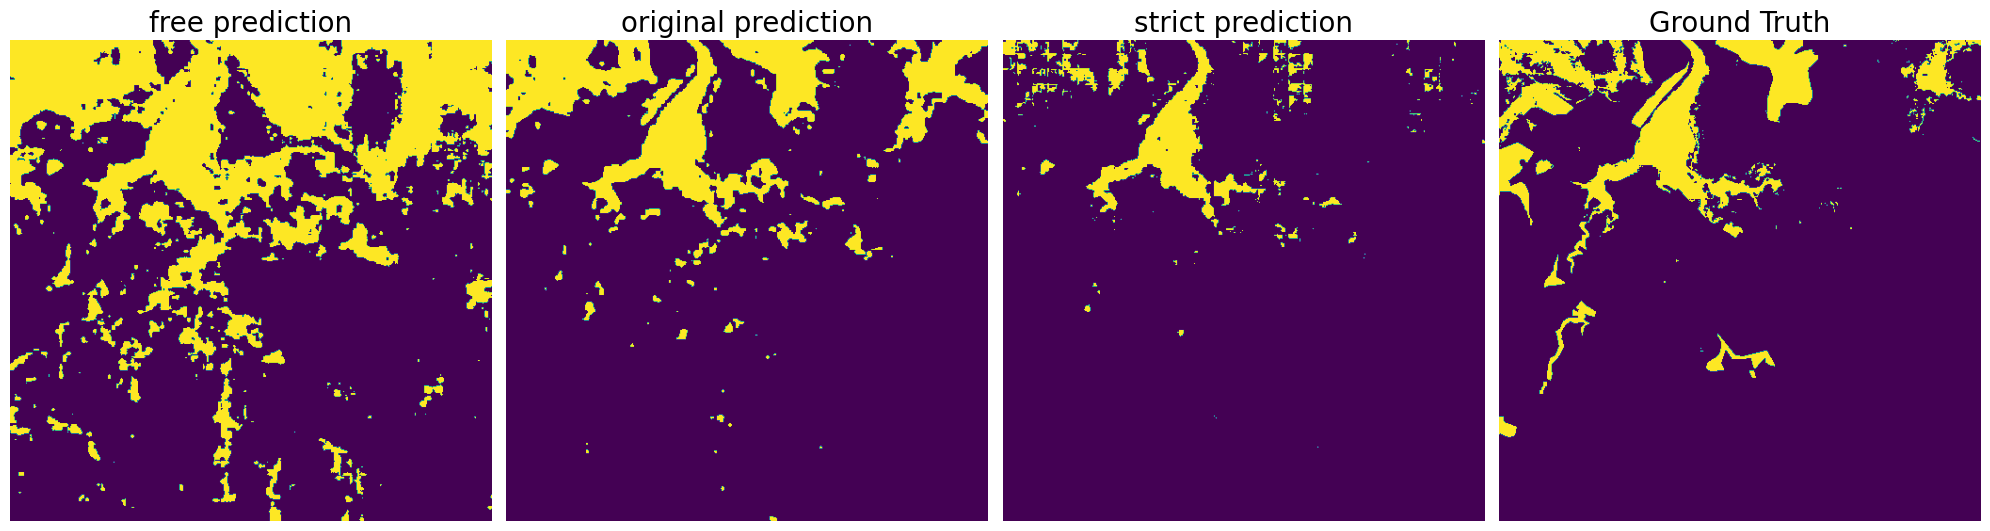

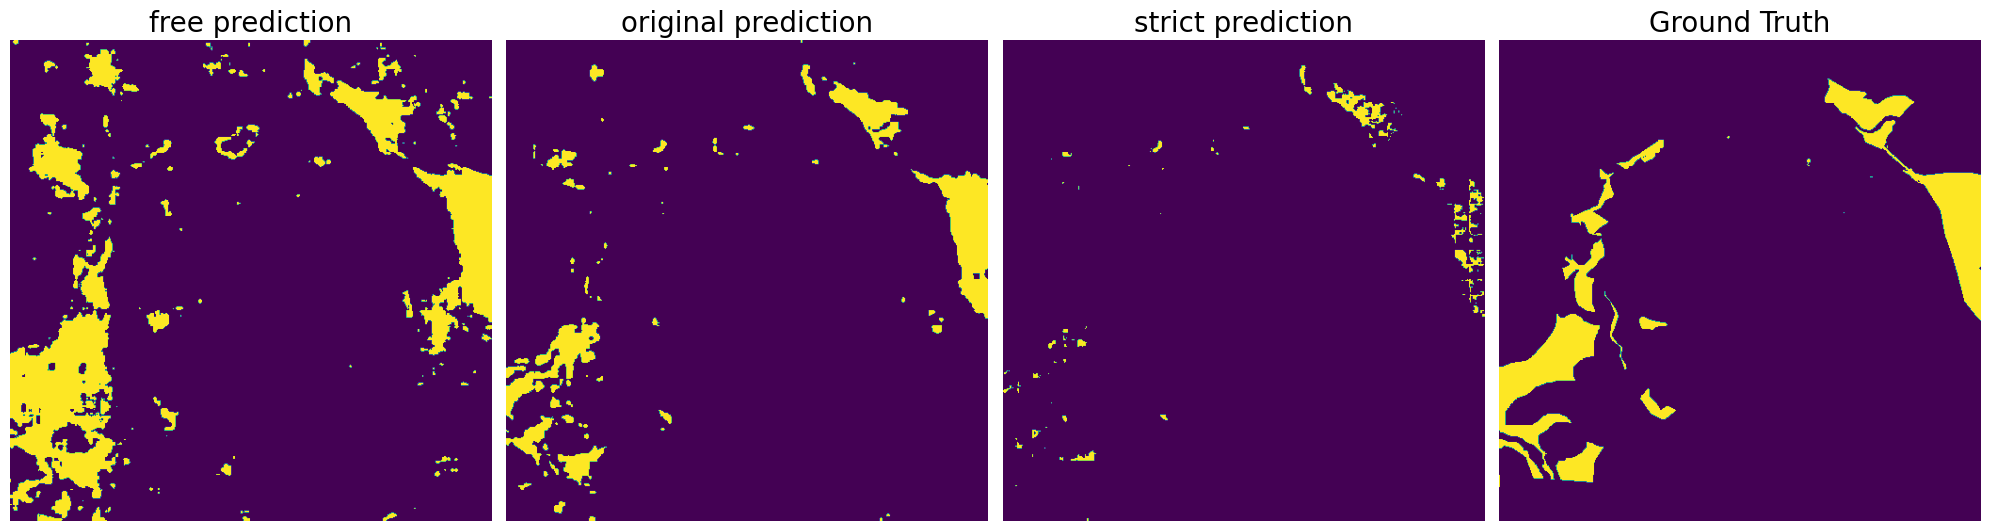

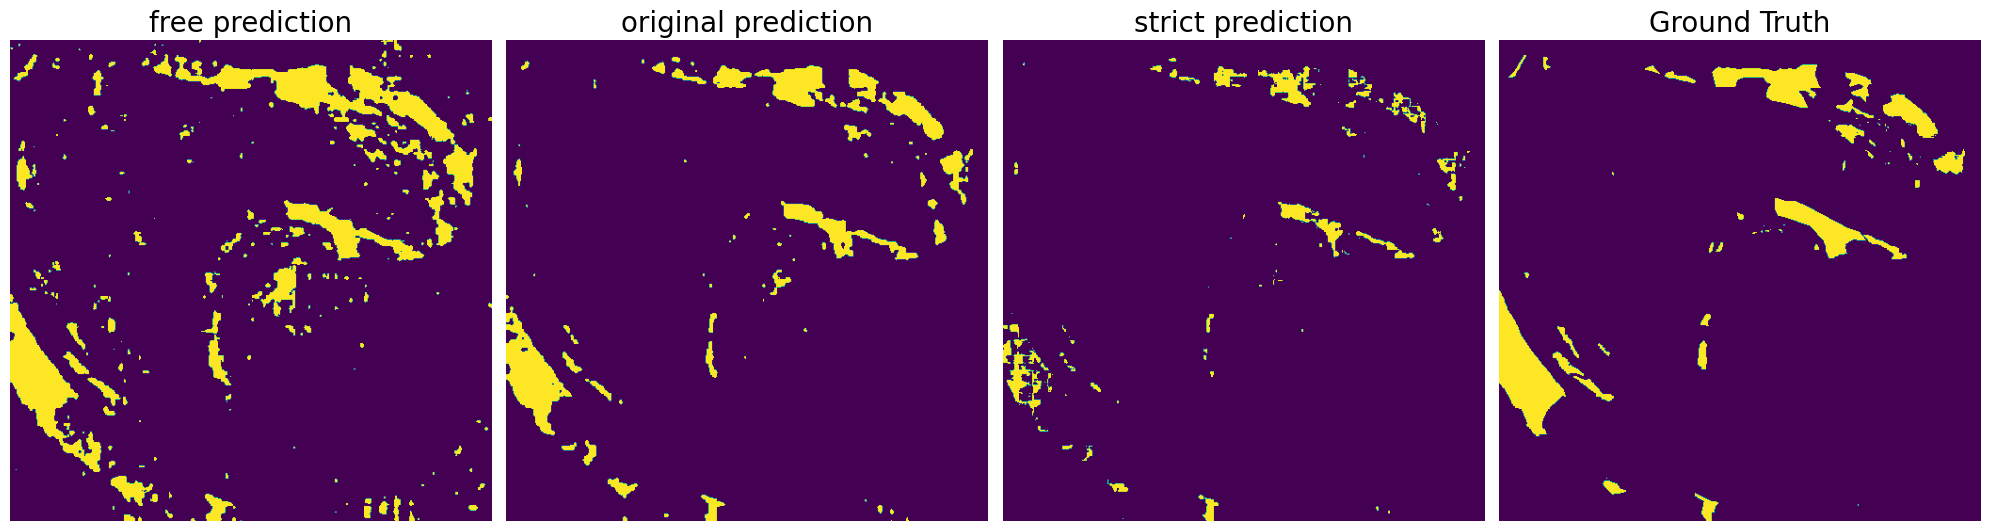

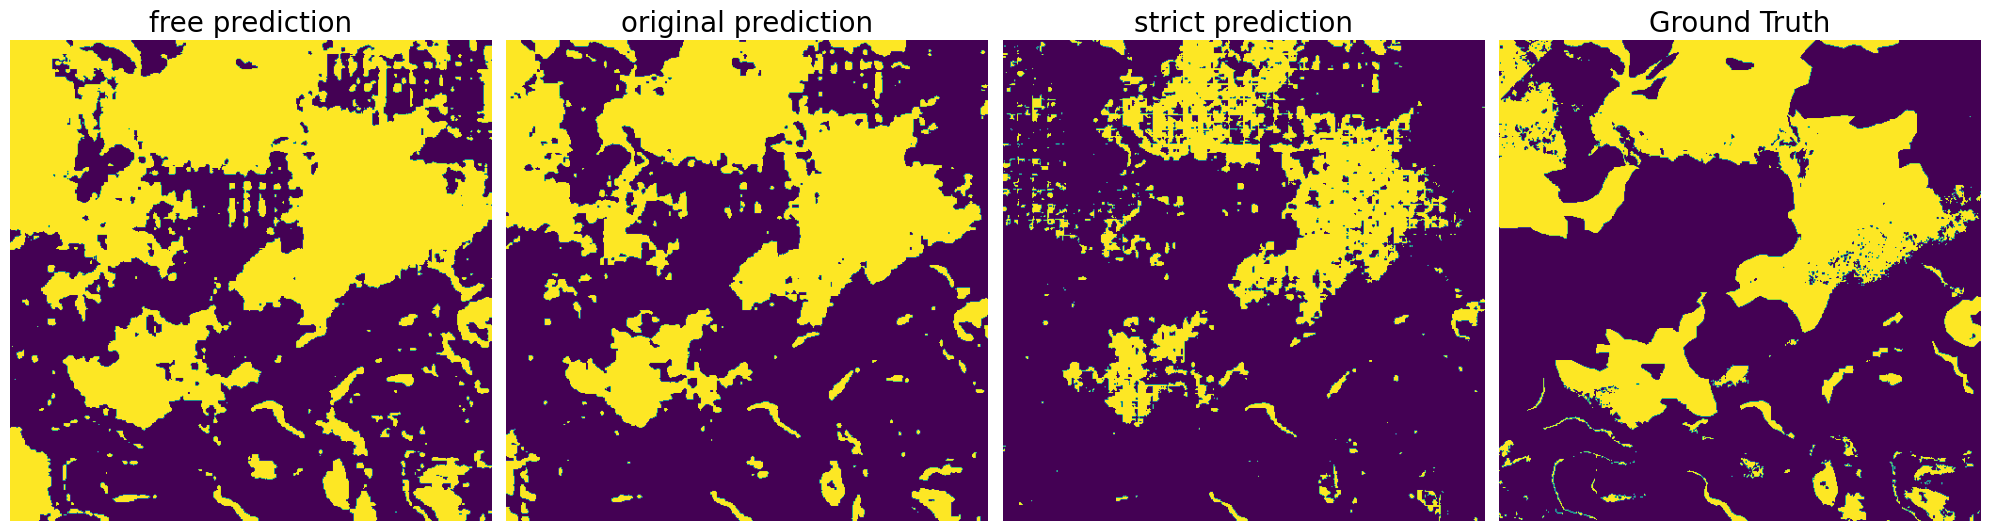

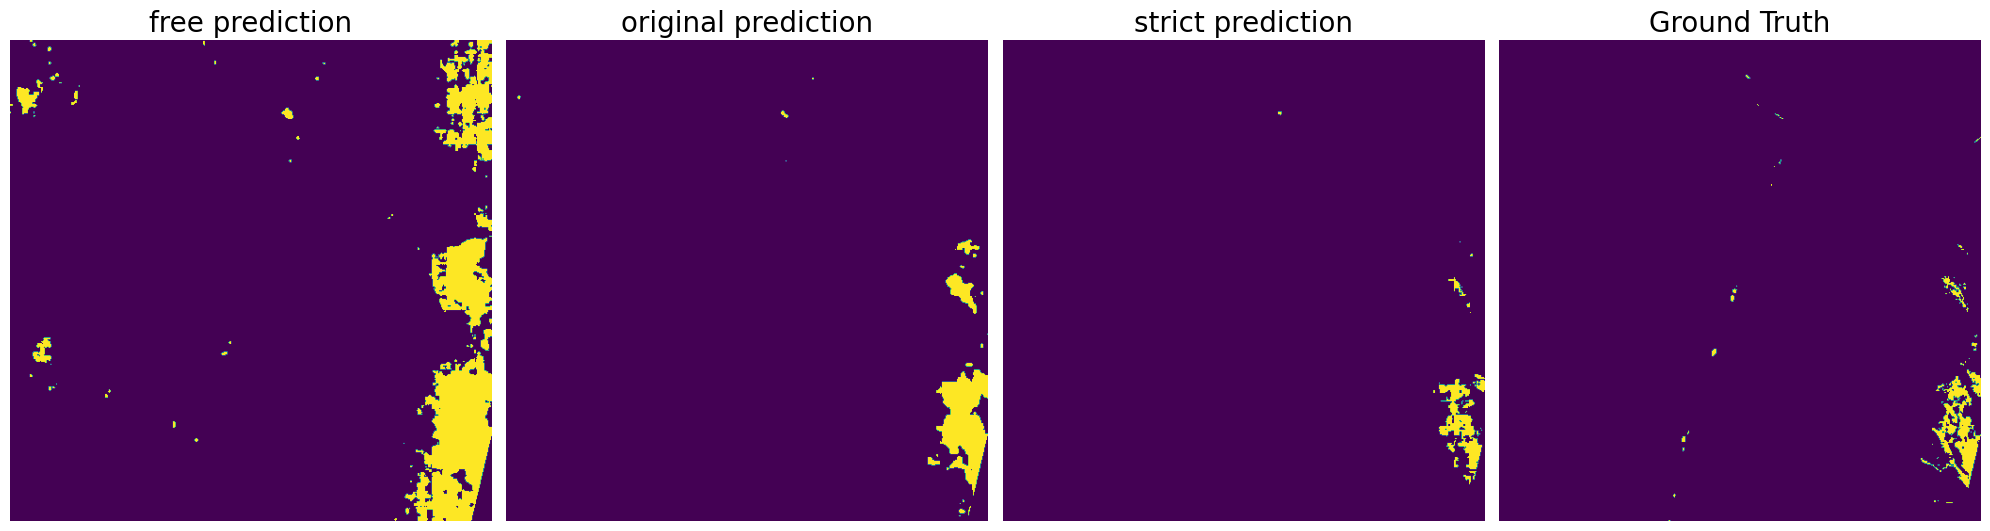

In [108]:
results, free_pred_pixel_gain, strict_pred_pixel_loss = supporting_preds(n_montecarlo=20, directory="inference_results", early_stop=10, control=False, show_img=True, free_gain = [], strict_loss = [])

Run control supporting predictions

[7141, 21665, 7877, 6156, 3909, 41213, 20915, 12502, 33741, 14185]
[10334, 40393, 773, 2059, 498, 22375, 11970, 8605, 40982, 3020]


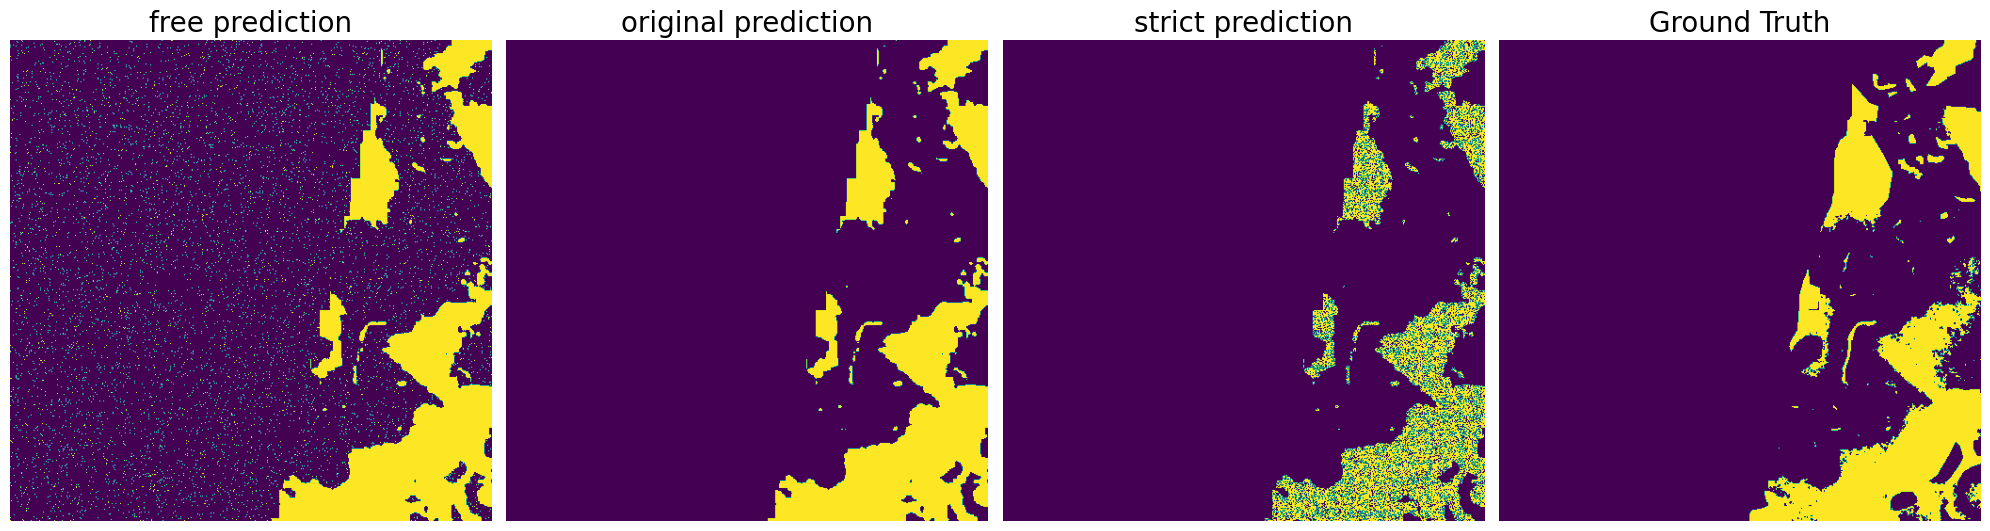

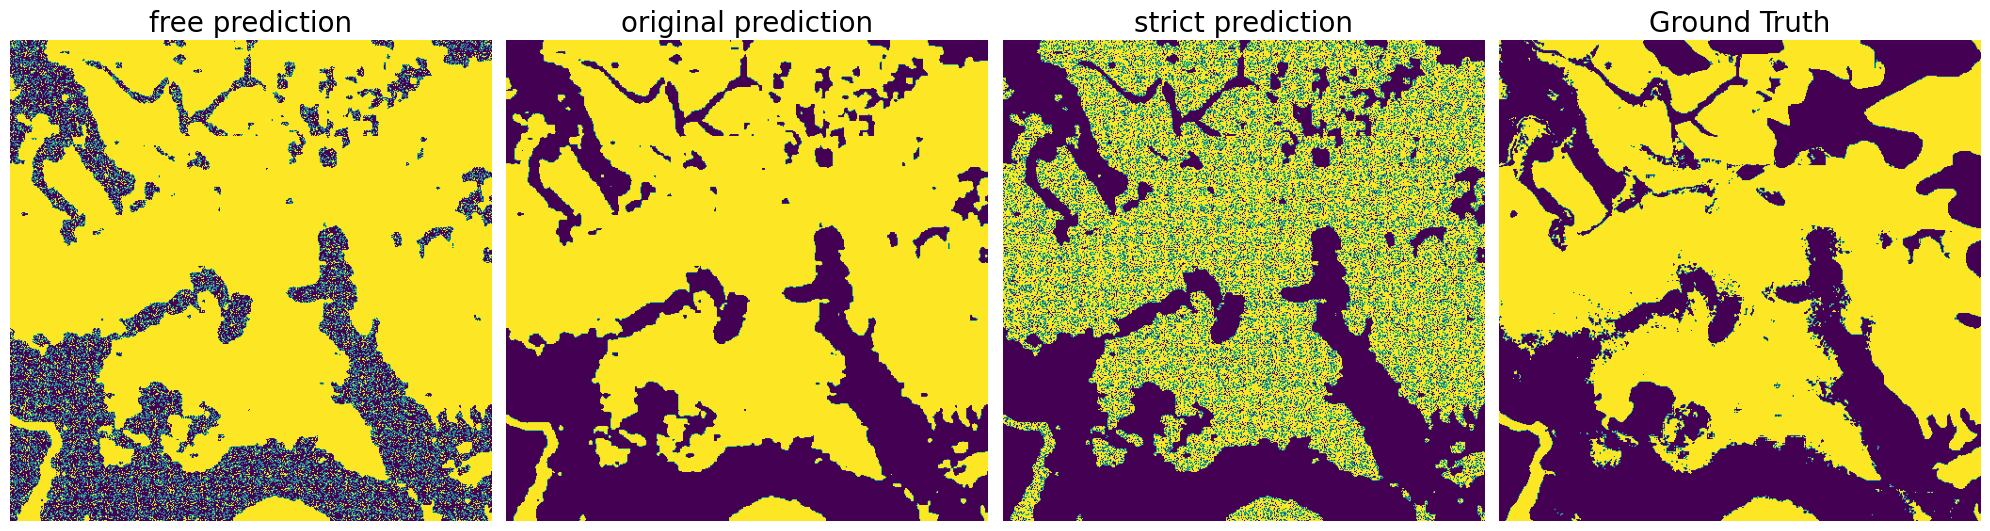

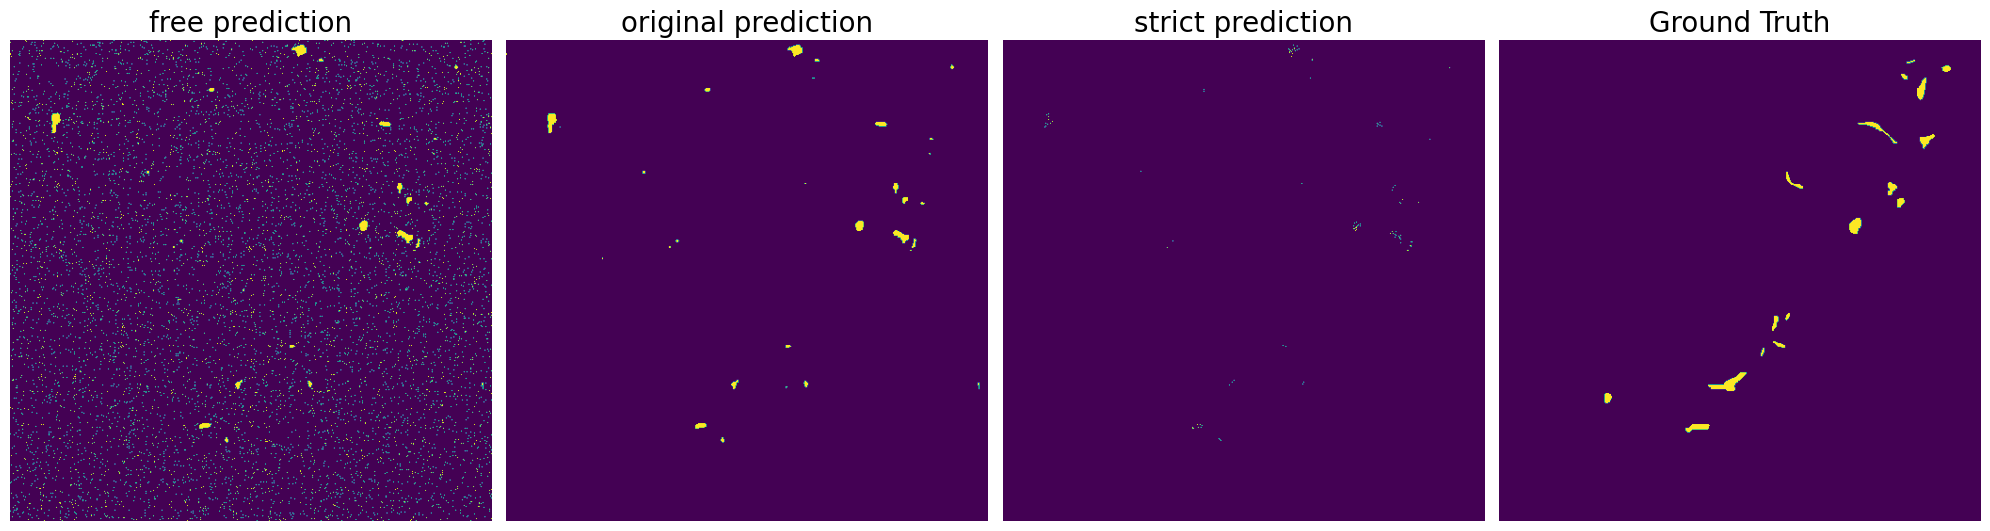

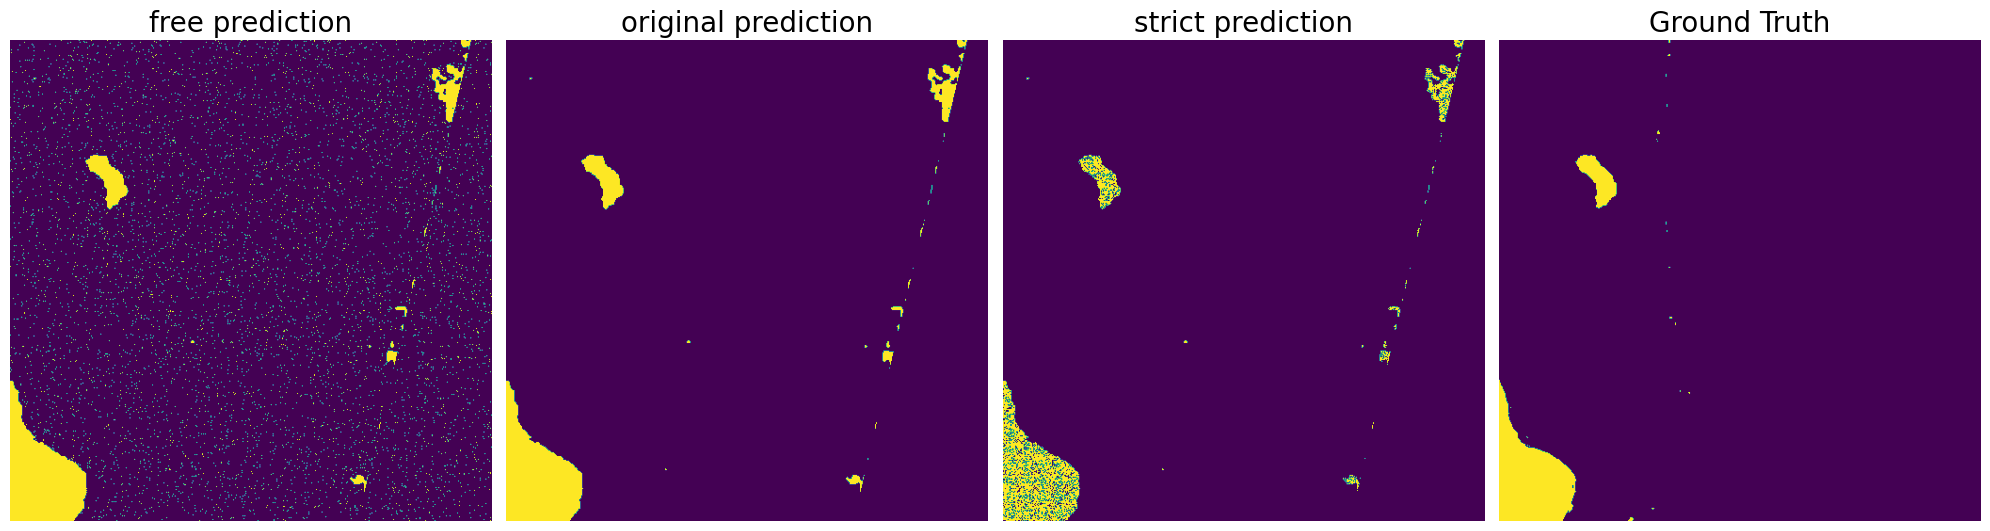

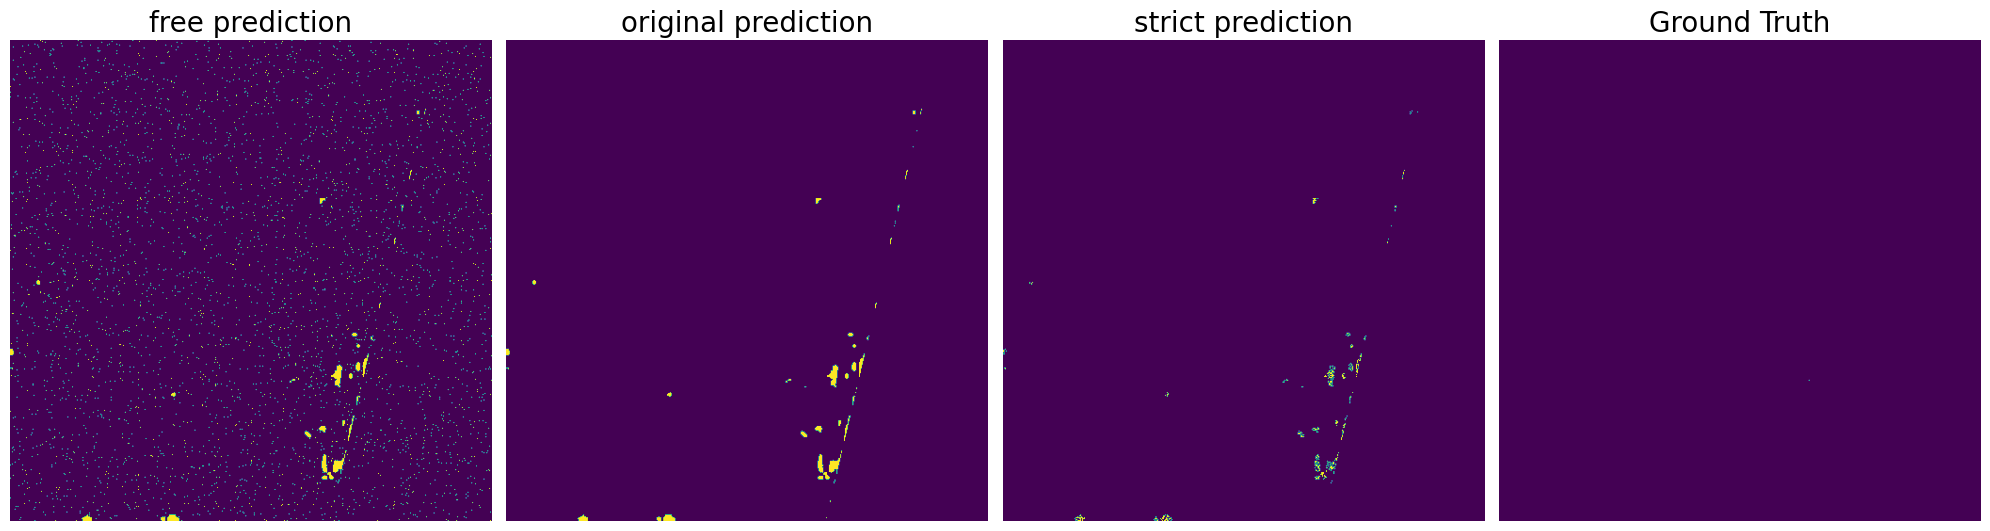

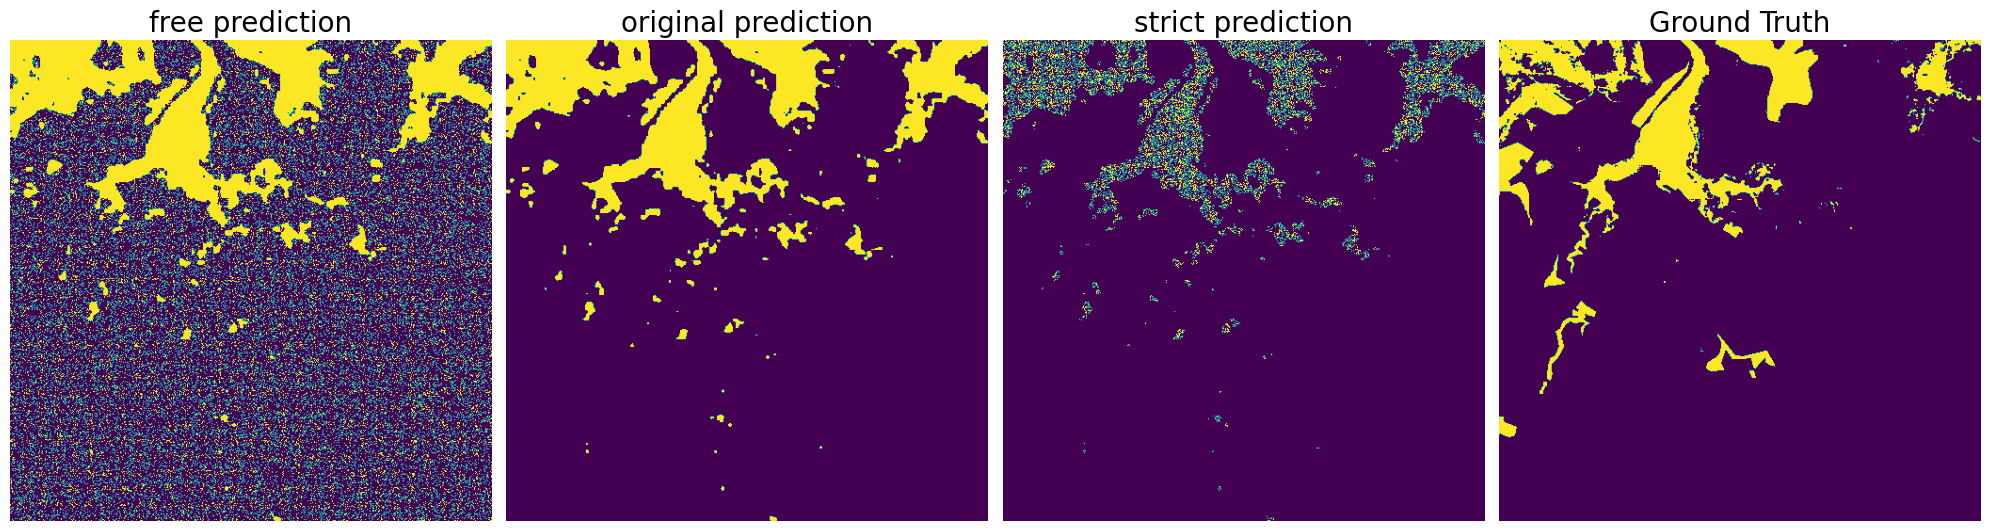

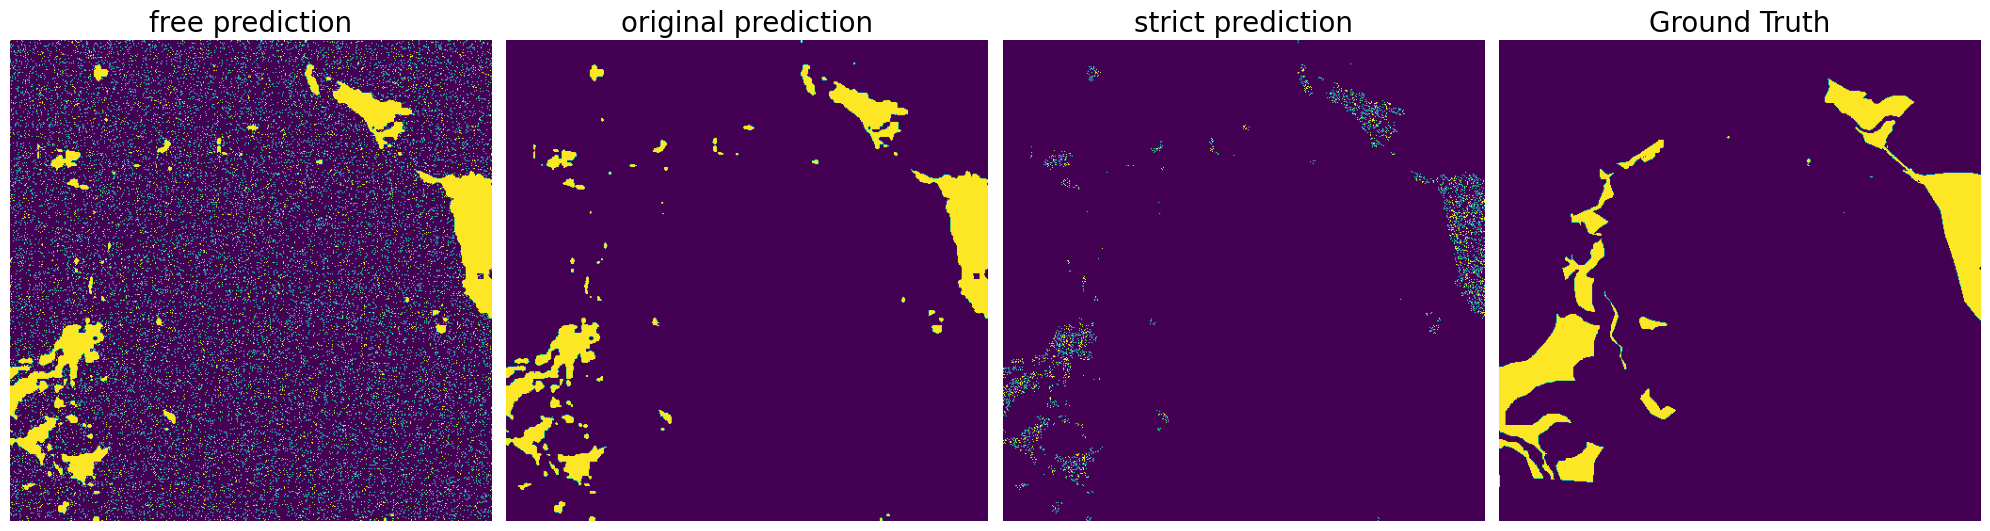

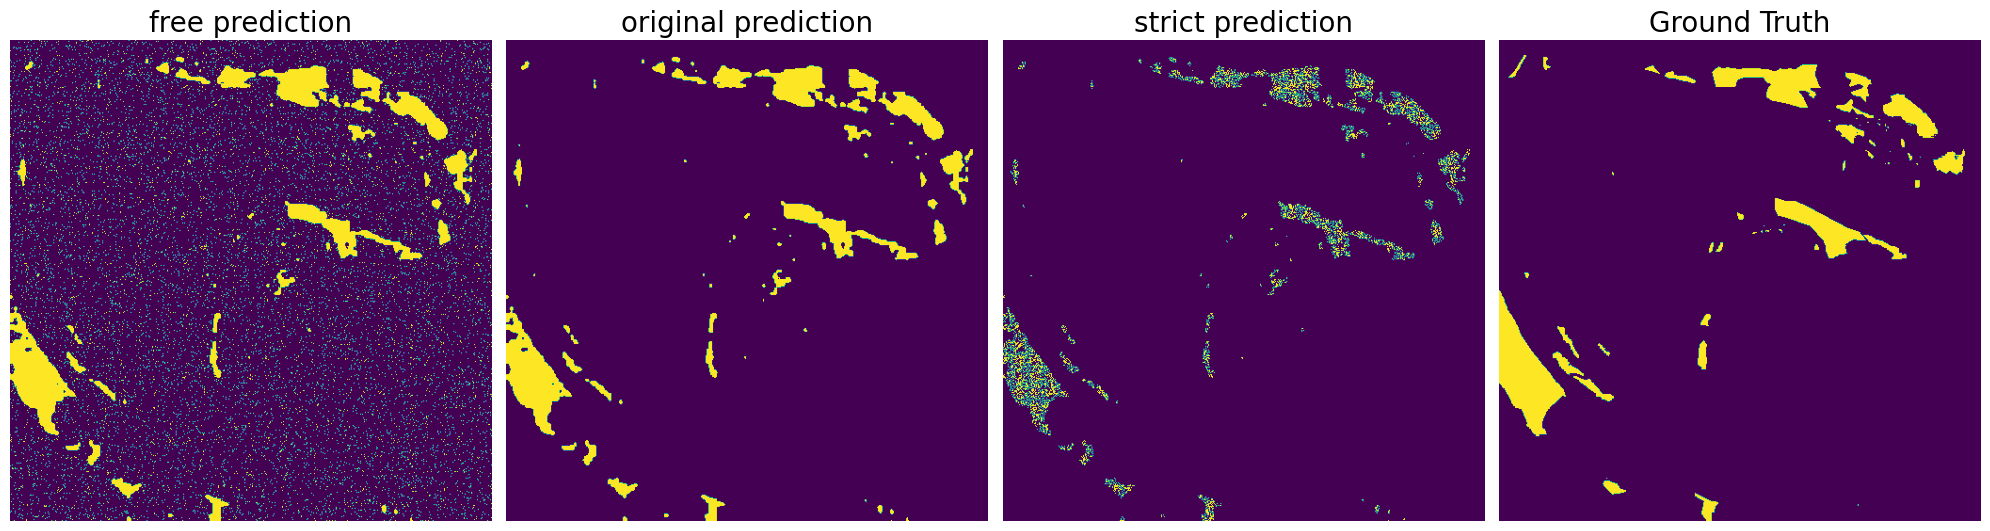

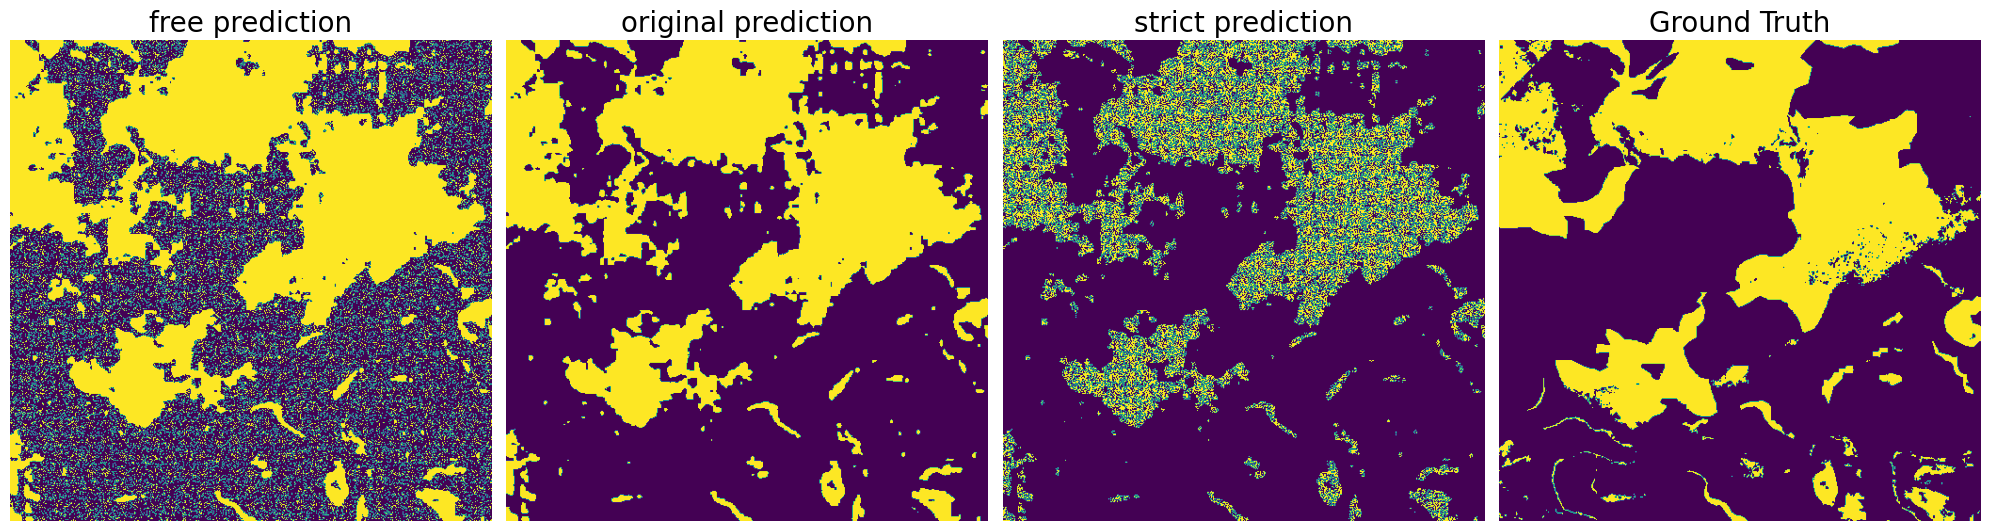

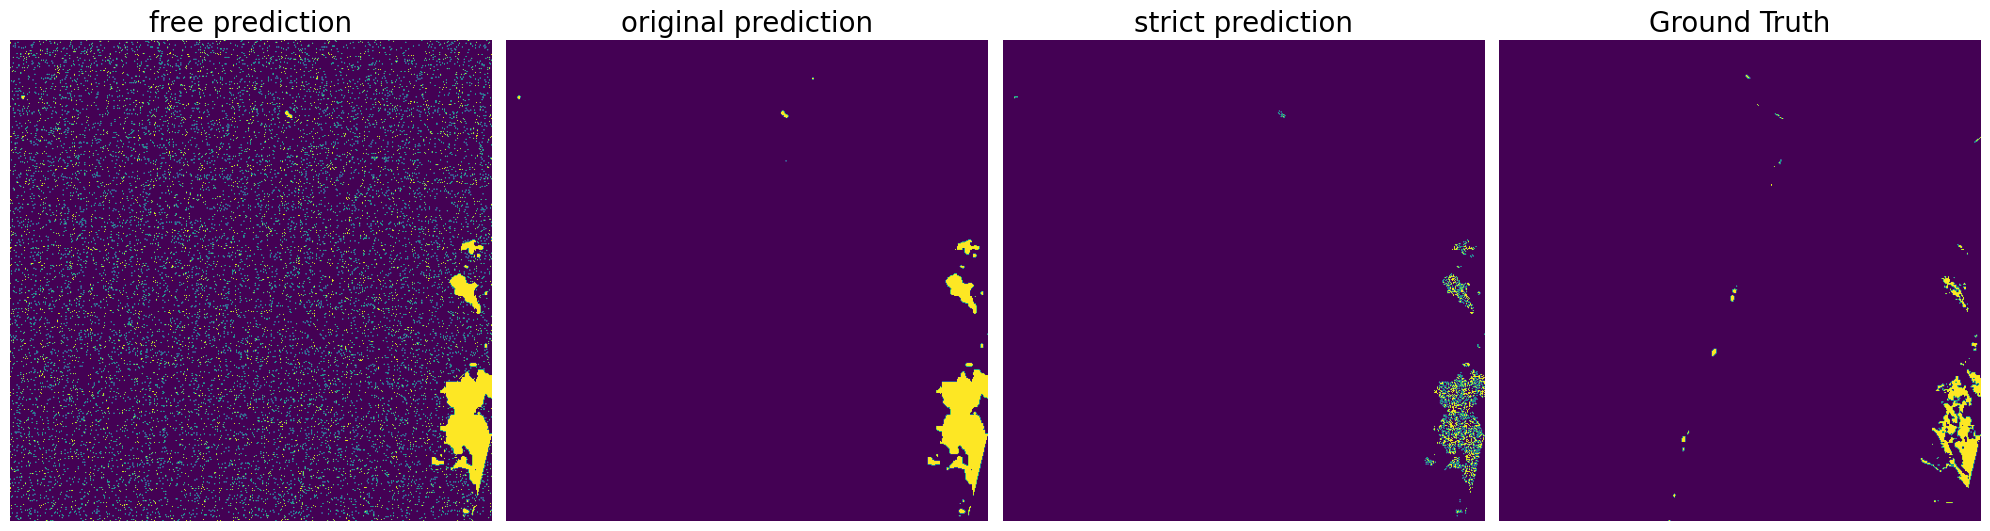

In [111]:
print(free_pred_pixel_gain)
print(strict_pred_pixel_loss)
control_results, _, _ = supporting_preds(n_montecarlo=20,directory="inference_results", early_stop=10, control=True, show_img= True, free_gain = free_pred_pixel_gain, strict_loss = strict_pred_pixel_loss)

In [112]:
def analyze_results(test_res):
    f1s = []
    stds = []

    def calculate_averages(test_res, idx, metric_name):
        avg_f1 = np.mean([value[0][idx] for value in test_res.values()])
        if idx == 0:
            avg_precision = np.mean([value[1][0] for value in test_res.values()])
            avg_recall = np.mean([value[1][1] for value in test_res.values()])
        else:
            avg_precision = np.mean([value[idx][2] for value in test_res.values()])
            avg_recall = np.mean([value[idx][1] for value in test_res.values()])
        

        print(f"Average {metric_name} F1 Score: {avg_f1:.4f}")
        print(f"Average {metric_name} Precision: {avg_precision:.4f}")
        print(f"Average {metric_name} Recall: {avg_recall:.4f}")
        print()


    print("==== Results Dashboard ====\n")
    calculate_averages(test_res, 0, "Original")
    calculate_averages(test_res, 1, "Strict")
    calculate_averages(test_res, 2, "Free")

 
    for key, value in test_res.items():
        stds.append(value[0][0])
        f1s.append(value[0][5])

    f1s = np.array(f1s)
    stds = np.array(stds)

    pearson_corr, pvalp = pearsonr(f1s, stds)
    spearman_corr, pvals = spearmanr(f1s, stds)

 
    print("==== Correlation Results ====")
    print(f"Pearson correlation coefficient: {pearson_corr:.4f}, p-value: {pvalp:.4e}")
    print(f"Spearman correlation coefficient: {spearman_corr:.4f}, p-value: {pvals:.4e}")
    print()

    # scatter plot with a line of best fit
    plt.figure(figsize=(10, 6))
    plt.scatter(f1s, stds, label='Data points')
    plt.plot(np.unique(f1s), np.poly1d(np.polyfit(f1s, stds, 1))(np.unique(f1s)), label='Line of best fit', color='red')
    plt.xlabel('F1 Scores')
    plt.ylabel('Standard Deviations')
    plt.title('Scatter plot with line of best fit for image uncertainty score and f1')
    plt.legend()
    plt.grid(True)
    plt.show()

# example call to the function with test_res
# test_res = {...}  # Your test results dictionary
# analyze_results(test_res)


==== Results Dashboard ====

Average Original F1 Score: 0.5501
Average Original Precision: 0.7043
Average Original Recall: 0.6392

Average Strict F1 Score: 0.4194
Average Strict Precision: 0.7509
Average Strict Recall: 0.6392

Average Free F1 Score: 0.4109
Average Free Precision: 0.4251
Average Free Recall: 0.7043

==== Correlation Results ====
Pearson correlation coefficient: -0.4732, p-value: 1.6716e-01
Spearman correlation coefficient: -0.4303, p-value: 2.1449e-01



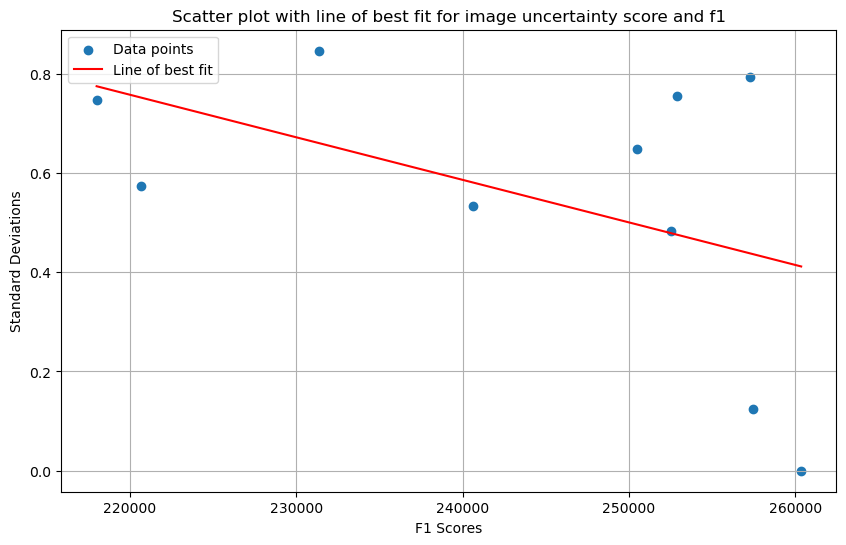

In [113]:
analyze_results(results)

==== Results Dashboard ====

Average Original F1 Score: 0.5501
Average Original Precision: 0.7043
Average Original Recall: 0.6392

Average Strict F1 Score: 0.3314
Average Strict Precision: 0.6440
Average Strict Recall: 0.6392

Average Free F1 Score: 0.3621
Average Free Precision: 0.3862
Average Free Recall: 0.7043

==== Correlation Results ====
Pearson correlation coefficient: -0.4732, p-value: 1.6716e-01
Spearman correlation coefficient: -0.4303, p-value: 2.1449e-01



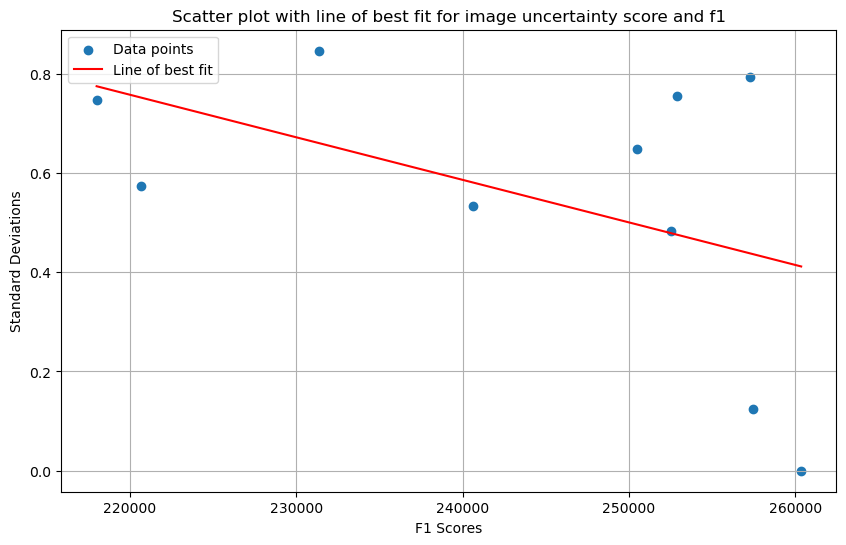

In [114]:
analyze_results(control_results)